In [323]:
# data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
# data.info()

In [324]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import plotly.express as px 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

In [325]:
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, silhouette_score, accuracy_score, confusion_matrix, mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [326]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-4-heart.csv')
data.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [327]:
data.duplicated().sum()
data.drop_duplicates(keep='first', subset=None, ignore_index=False,inplace=True)
data.duplicated().sum()

0

In [328]:
mis_val = data.isna().sum() * 100 / len(data)
mis_val.sort_values(ascending=False)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

In [329]:
num_val = ['age','trestbps','chol','thalach','oldpeak' ]
cat_val = ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [330]:
col_transf = ColumnTransformer( 
    [ 
        ('num', StandardScaler(), num_val),
        ('cat', OrdinalEncoder(), cat_val)
    ]
)


<AxesSubplot:title={'center':'Correlation Matrix'}>

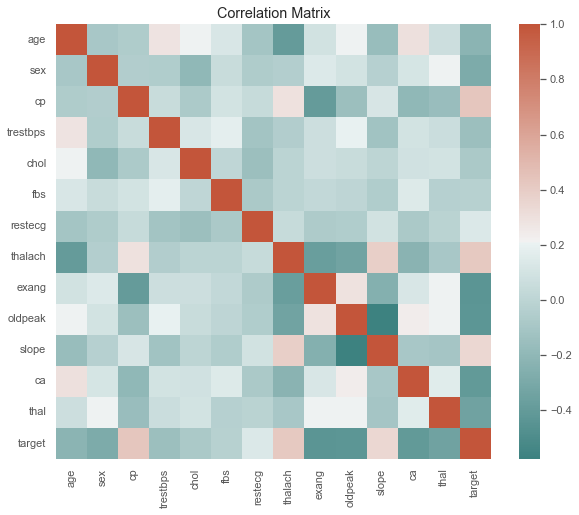

In [331]:
data_corr = data.corr()

f,ax = plt.subplots(figsize=(10,8))
ax.set_title('Correlation Matrix')

sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(190,20, as_cmap=True), square=True, ax=ax)

In [332]:
y = data.target 
x = data.drop(columns=['target'])


In [333]:
x = pd.DataFrame(col_transf.fit_transform(x))


In [334]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [335]:
logreg = LogisticRegression()

logreg.fit(x_train,y_train)

y_true = y_test 
y_pred = logreg.predict(x_test)

accu_scr = accuracy_score(y_true,y_pred)

modperf = pd.DataFrame( 
    [ 
        'LogisticRegression', accu_scr
    ]
).transpose()

modperf.columns = ['Method', 'Test Accuracy']

modperf

,Method,Test Accuracy
0,LogisticRegression,0.824176


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Values', ylabel='True Values'>

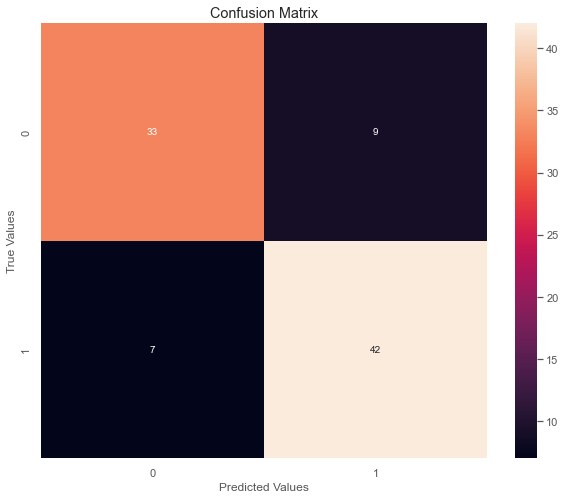

In [336]:
con_dic = { 
    'y_true':y_true,
    'y_pred':y_pred
}

conmat_cols = pd.DataFrame( 
    con_dic, columns=['y_true', 'y_pred']

)

confusion_matrix = pd.crosstab(
    conmat_cols['y_true'], conmat_cols['y_pred'], rownames=['True Values'], colnames=['Predicted Values']
)

f,ax = plt.subplots(figsize=(10,8))
ax.set_title('Confusion Matrix')
sns.heatmap(confusion_matrix, annot=True)



c:\Users\amunv\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Accuracy Line Plot'}>

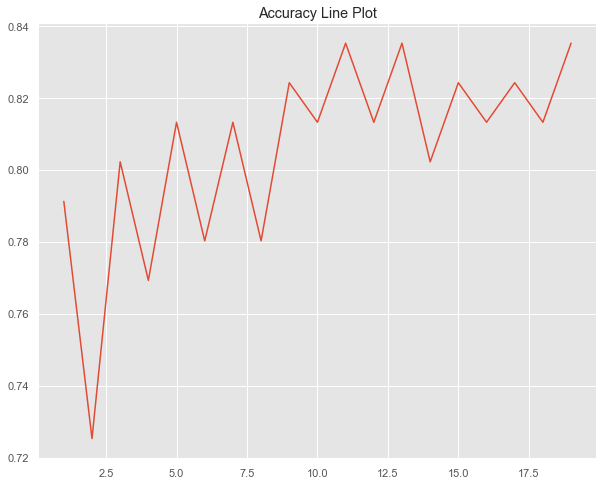

In [337]:
accuracies = []

for N in range(1,20):

    knn = KNeighborsClassifier(n_neighbors=N)

    knn.fit(x_train,y_train)

    y_pred = knn.predict(x_test)

    accu = accuracy_score(y_true,y_pred)

    accuracies.append(accu)

accuracies = np.array(accuracies)

f,ax = plt.subplots(figsize=(10,8))

ax.set_title('Accuracy Line Plot')

sns.lineplot(np.arange(1,20),accuracies)

In [338]:
best_k = np.argmax(accuracies)
best_accu = np.max(accuracies)

perfmod = pd.DataFrame( 
    [ 
        'Accurcay Score', best_k, best_accu
    ]
).transpose()

perfmod.columns = ['Method', 'Best K', 'Best Accuracy']

perfmod

,Method,Best K,Best Accuracy
0,Accurcay Score,10,0.835165
